# Planètes et Galaxie

/!\ J'ai modifié plusieurs fichiers *.py* afin de faciliter le traitement réalisé ici. /!\\*

Principalement :

* *SolarSystem* et *Galaxy* intègrent maintenant le choix du schéma d'intégration en paramètre ;
* *SolarSystem* et *Galaxy* intègrent également le choix de $\theta$ (paramètres de l'algorithme de Barnes Hut) en paramètre.

Ces modifications ont des répercutions sur les autre fichiers *.py*, en particulier : tous les schémas d'intégration, ainsi que *energy.py* et *numba_functions.py* du module *Barnes Hut*.

J'ai également ajouté dans le répertoire racine du projet, un fichier *utils.py* qui permet de calculer l'energie d'un système simulé ici (avec les hypothèses associées).

# TODO :
* Pour *Galaxie*, il me semble que les masses sont initialisées avec un certain degré d'aléatoire. Je dois donc les stocker pour chaque simulation.

In [1]:
from examples.solar import SolarSystem
from examples.galaxy import Galaxy
import importlib
import numpy as np
import pygalaxy
from docopt import docopt
from pygalaxy.barnes_hut_array import compute_energy

In [2]:
from time import time

# importing function to compute the energy
from utils import get_energy_solar, get_energy_planet # get_center_of_mass

# Premier test avec tous les schémas

## Choix des paramètres et du système à intégrer

In [3]:
# last 3 are symplectics
schemes = ['RK4', 'ADB6', 'Euler_symplectic','Stormer_verlet','Optimized_815']

system = 'SolarSystem' # 'Galaxy', 'SolarSystem'

if(system == 'Galaxy'):
    # TODO : make initialization of the galaxy and solar system the same. Here the init of the solar system is automatically done inside,
    # whereas in the case of the galaxy it's done outside (via blackhole here)
    # solar system -> blackhole 
    # (makes sense how it was done, since the solar system remains the same anyway)
    blackHole = [
            {
                'coord': [0, 0],
                'mass': 1000000,
                'svel': 1,
                'stars': 20,
                'radstars': 3
            },

            {
                'coord': [3, 3],
                'mass': 1000000,
                'svel': 0.9,
                'stars': 10,
                'radstars': 1
            }]
    # args en plus 
    args = {
        'theta' : 0.5
    }
    # simu parameters
    dt_in_days = 0.1
    number_of_steps = 10
else:
    # args en plus 
    args = {
        'theta' : 0.5
    }
    # simu parameters
    dt_in_days = 10
    number_of_steps = 10

## Plot des trajectoires des planètes

In [6]:
print('Batch of simulations with dt = {} days and for {} steps. Total : {} days.\n'.format(dt_in_days,number_of_steps, dt_in_days*number_of_steps))
saving_lists = []
# TODO : saving_mass = []
for i,scheme in enumerate(schemes) :
    if(system=='Galaxy'):
        sim = Galaxy(blackHole, dt = dt_in_days*pygalaxy.physics.day_in_sec, display_step=number_of_steps,
                    scheme = scheme, args_method = args)
    else: 
        sim = SolarSystem(dt = dt_in_days*pygalaxy.physics.day_in_sec, display_step=number_of_steps,
                      scheme = scheme, args_method = args)
    init_energy = get_energy_solar(sim.particles, sim.mass, verbose = False) # I think this takes LOADS of time for the galaxy.
                                                                            # Note that this algo is O(N2) whereas computing the energy
                                                                            # using the barnes hut quad tree is O(NlogN) which is why
                                                                            # printed time is quite fast !
    t1=time()
    saving_lists.append(sim.next(return_pos = True)) # in theory, it already computes energy inside next() (inside the scheme used in fact)
    t2=time()
    # see if we can get it and plot the energy as a function of time
    final_energy = get_energy_solar(sim.particles, sim.mass, verbose = False)
    print('{} : {} secs. Fractional change in Energy: {:.5} %'.format(scheme, "{:e}".format(t2-t1),"{}".format(100*(final_energy-init_energy)/init_energy)))
    print('Initial energy being : {:.3} J.\n'.format(init_energy))

Batch of simulations with dt = 10 days and for 10 steps. Total : 100 days.

RK4 : 7.063627e-03 secs. Fractional change in Energy: 0.232 %
Initial energy being : 9.16e+40 J.

ADB6 : 1.961946e-03 secs. Fractional change in Energy: 0.102 %
Initial energy being : 9.16e+40 J.

Euler_symplectic : 2.862930e-03 secs. Fractional change in Energy: 0.154 %
Initial energy being : 9.16e+40 J.

Stormer_verlet : 3.001451e-03 secs. Fractional change in Energy: 0.232 %
Initial energy being : 9.16e+40 J.

Optimized_815 : 8.034182e-02 secs. Fractional change in Energy: 0.231 %
Initial energy being : 9.16e+40 J.



Schéma : RK4


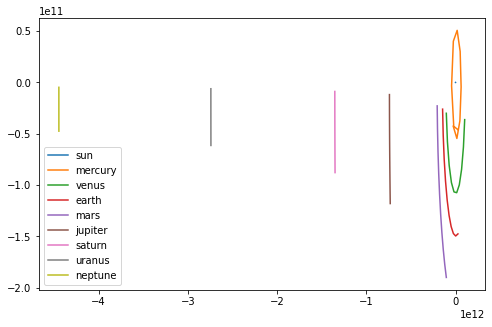

Schéma : ADB6


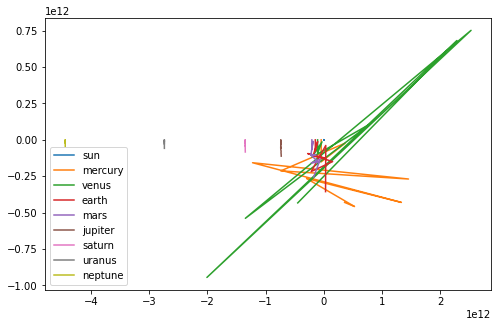

Schéma : Euler_symplectic


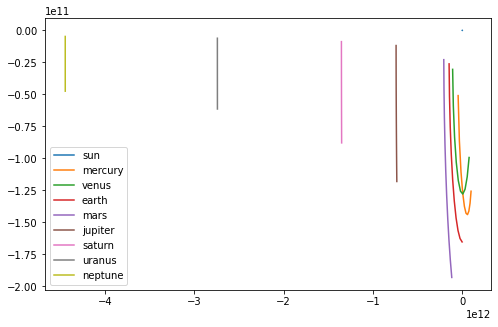

Schéma : Stormer_verlet


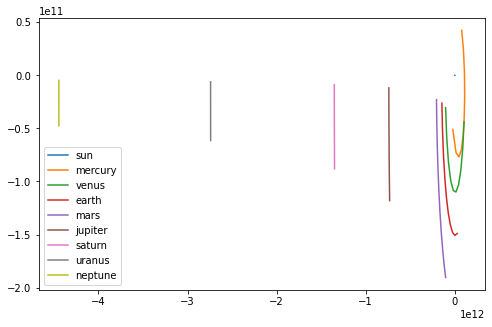

Schéma : Optimized_815


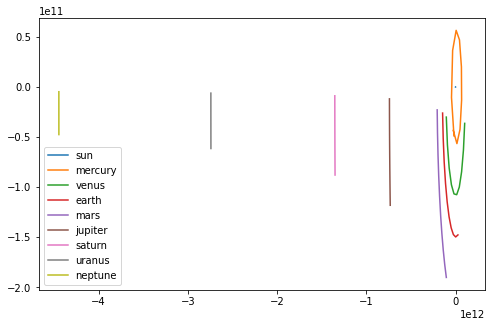

In [7]:
""" sous forme de scatter
import matplotlib.pyplot as plt
for k in range(len(saving_lists)):
    coords_list = saving_lists[k]
    fig, ax = plt.subplots(figsize=(8,5)) 
    for coords in coords_list :
        plt.scatter(coords[:, 0], coords[:, 1], c='black', s=1)
    plt.show()
"""
names = ['sun', 'mercury', 'venus', 'earth', 'mars', 'jupiter', 'saturn', 'uranus', 'neptune']

import matplotlib.pyplot as plt
for k in range(len(saving_lists)):
    print('Schéma : {}'.format(schemes[k]))
    fig, ax = plt.subplots(figsize=(8,5)) 
    pos_ = saving_lists[k]
    shape = pos_.shape
    positions = np.moveaxis(saving_lists[k], 0, -1)
    for planet in range(len(positions)):
        if(system=='SolarSystem'):
            plt.plot(positions[planet][0],positions[planet][1], label = names[planet])# [nb_steps, nb_planets,2] -> [nb_planets,2,nb_steps]
        else :
            plt.plot(positions[planet][0],positions[planet][1])
    if(system=='SolarSystem'): plt.legend(loc='best')
    plt.show()


# Plotting de l'énergie en fonction du temps 

  

## Pour chaque planète

sun : 


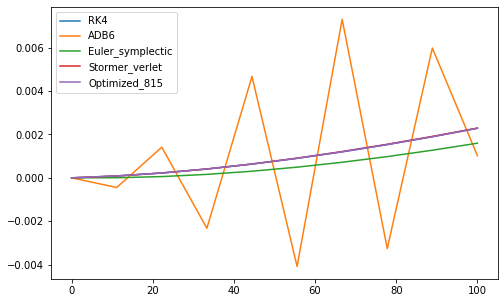

mercury : 


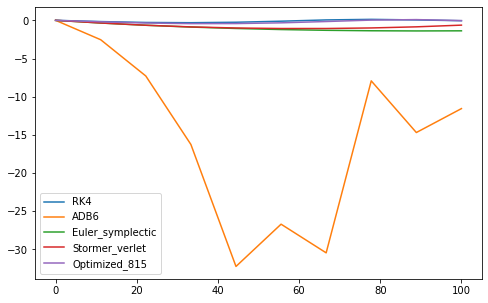

venus : 


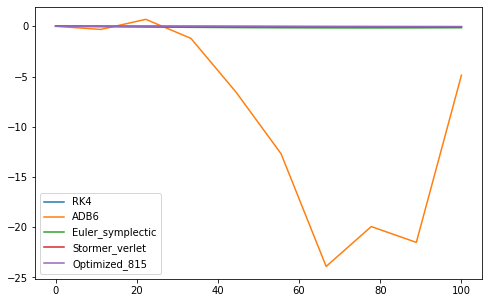

earth : 


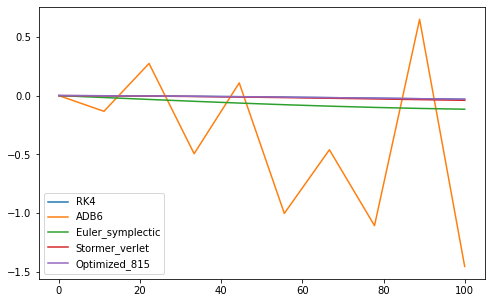

mars : 


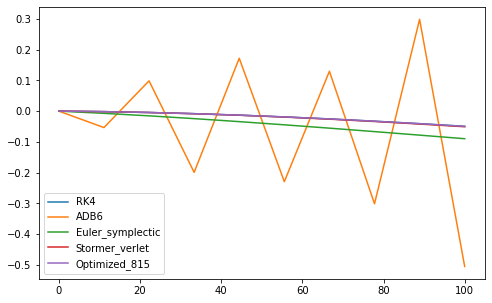

jupiter : 


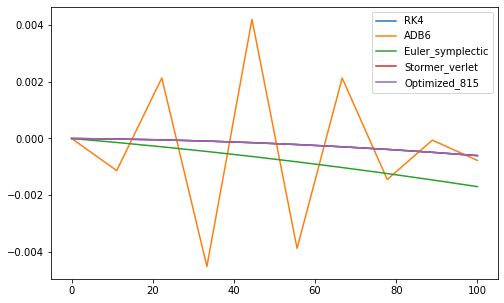

saturn : 


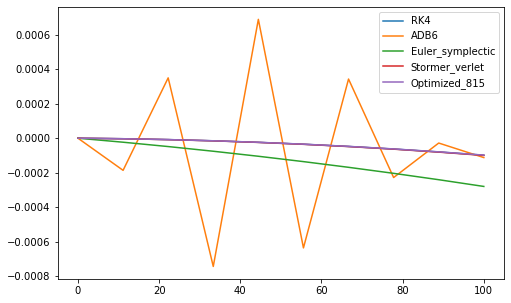

uranus : 


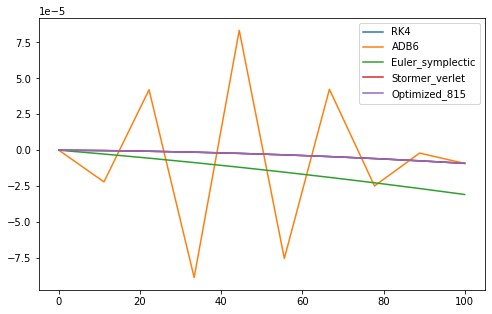

neptune : 


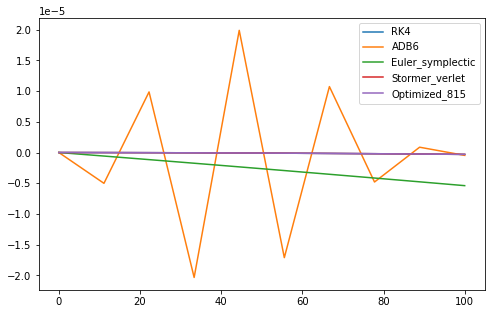

In [8]:
if(system=='SolarSystem'):
    masses = np.array([  1.989e30, # sun
                      .33011e24, #mercury
                      4.8675e24, #venus
                       5.972e24, #earth
                      6.4171e23, #mars
                      1898.19e24, #jupiter
                       568.34e24, #saturn
                       86.813e24, #uranus
                      102.413e24, #neptune 
                    ]) 
else:
    masses = sim.mass

energies_all_schemes = np.zeros((len(masses),len(schemes),number_of_steps))

for k in range(len(saving_lists)): # number of schemes
    pos_ = saving_lists[k]
    shape = pos_.shape #[nb_steps,nb_planets,2]
    #positions = np.moveaxis(saving_lists[k], 1, 0) #[nb_planets,nb_steps,2]
    list_energies = np.zeros((shape[1],shape[0])) # [nb_planets, nb_steps]
    for step in range(shape[0]):
        for idx_planet in range(0,shape[1]):
            energies_all_schemes[idx_planet,k,step]=get_energy_planet(pos_[step], masses, planet_index = idx_planet, verbose = False)

# energies_all_scheme contains energy ordered by planet, then schemes then time step

Time = np.linspace(0,number_of_steps*dt_in_days,number_of_steps)

for idx_planet in range(0,shape[1]):
    fig, ax = plt.subplots(figsize=(8,5)) 
    # we don't plot for the sun
    if(system=='SolarSystem'): print('{} : '.format(names[idx_planet]))
    for scheme in range(len(schemes)):
        plt.plot(Time,(energies_all_schemes[idx_planet][scheme]-energies_all_schemes[idx_planet][scheme][0])/energies_all_schemes[idx_planet][scheme], label=schemes[scheme])
    plt.legend(loc='best')
    plt.show()
    

# Pour chaque scheme, par planète :

RK4 : 


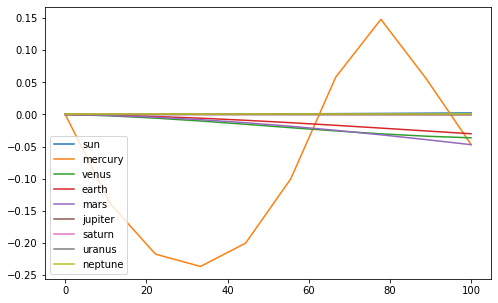

ADB6 : 


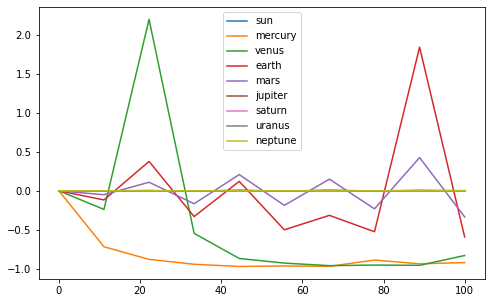

Euler_symplectic : 


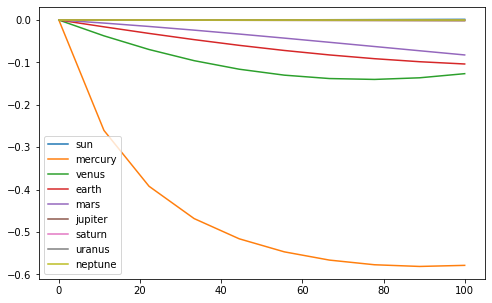

Stormer_verlet : 


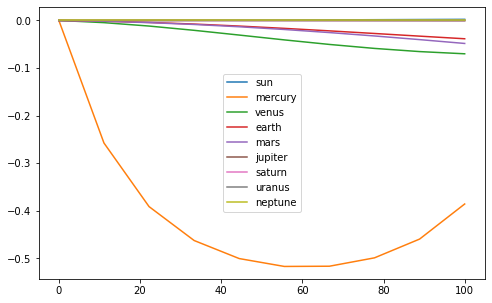

Optimized_815 : 


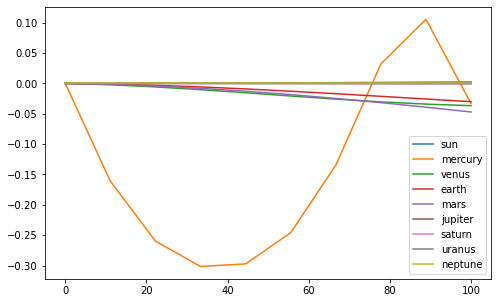

In [9]:
Time = np.linspace(0,number_of_steps*dt_in_days,number_of_steps)

for scheme in range(len(schemes)):
    fig, ax = plt.subplots(figsize=(8,5)) 
    # we don't plot for the sun
    print('{} : '.format(schemes[scheme]))
    for idx_planet in range(0,shape[1]):
        if(system=='SolarSystem'):
            plt.plot(Time,(energies_all_schemes[idx_planet][scheme]-energies_all_schemes[idx_planet][scheme][0])/energies_all_schemes[idx_planet][scheme][0], label=names[idx_planet])
        else:
            plt.plot(Time,(energies_all_schemes[idx_planet][scheme]-energies_all_schemes[idx_planet][scheme][0])/energies_all_schemes[idx_planet][scheme][0])
    if(system=='SolarSystem'): plt.legend(loc='best')
    plt.show()

## Pour chaque scheme, pour tout le système :

In [10]:
energy_system = np.zeros((len(schemes), number_of_steps))

for idx_scheme in range(len(schemes)):
    E_tot = np.zeros((number_of_steps))
    for idx_planet in range(shape[1]):
        E_tot+=energies_all_schemes[idx_planet][idx_scheme]
    energy_system[idx_scheme] = E_tot


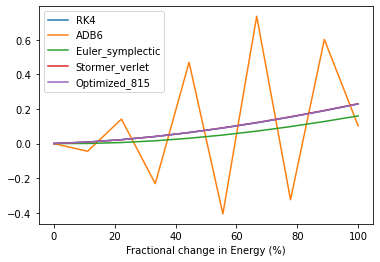

In [11]:
Time = np.linspace(0,number_of_steps*dt_in_days,number_of_steps)
for idx_scheme in range(len(schemes)):
    plt.plot(Time, 100*(energy_system[idx_scheme]-energy_system[idx_scheme][0])/energy_system[idx_scheme][0], label=schemes[idx_scheme])
plt.legend(loc='best')
plt.xlabel('Fractional change in Energy (%)')
plt.show()